# Intro
This notebook code is used to apply the Self-Organizing Map (SOM) alghoritm to the Chandra Source Catalog (CSC) version 1. This is the first attempt to apply the SOM algorithm and the following code is specifically being used to test the features of the minisom package.

In [20]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord
from astropy import units as u
from minisom import MiniSom
import seaborn as sns
import pandas as pd
import numpy as np

Loading the raw and log-normalized datasets from CSV files into pandas DataFrames.

In [21]:
raw_dataset_path = './data/cluster_csc_simbad.csv'
dataset_path = './data/cluster_csc_simbad_log_normalized.csv'

# Load the dataset
raw_df = pd.read_csv(raw_dataset_path)
df = pd.read_csv(dataset_path)

/var/folders/lr/d8nq9v9x525g290h3kqjrbgw0000gq/T/ipykernel_37934/3365918053.py:5: DtypeWarning: Columns (56,63,64,65,66,67,68,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(raw_dataset_path)


Extracting the right ascension (ra) and declination (dec) from the raw dataset and converts them into galactic coordinates.

In [22]:
# get ra and dec
ra = raw_df['ra']
dec = raw_df['dec']
# transform it to galactic coordinates
c = SkyCoord(ra, dec, frame='icrs', unit=u.deg)
l_rad = c.galactic.l.wrap_at('180d').radian
b_rad = c.galactic.b.radian

Extracting the cluster labels derived from applying the unsupervised learning technique, Gaussian Mixture Models (GMMs), to the Chandra Source Catalog (CSC).

In [23]:
GMM_cluster_labels = df['cluster']
df = df.drop(columns=['cluster'])

## Features Selection

In this notebook we try to select a portion of the initial features, more specifically:
- hard_hm
- hard_hs
- hard_ms
- bb_kt
- powlaw_gamma

In [24]:
# Drop all the columns expect the ones we want to use
# All columns: ['hard_hm', 'hard_hs', 'hard_ms', 'bb_kt', 'powlaw_gamma', 'var_prob_b', 'var_prob_h', 'var_prob_s', 'var_ratio_b', 'var_ratio_h', 'var_ratio_s', 'var_newq_b']

subset_of_df = df.drop(columns=['var_prob_b', 'var_prob_h', 'var_prob_s', 'var_ratio_b', 'var_ratio_h', 'var_ratio_s', 'var_newq_b'])
# get the number of features
features = subset_of_df.shape[1]

## Data Analysis
After pre-processing

In [25]:
subset_of_df.head()

,hard_hm,hard_hs,hard_ms,bb_kt,powlaw_gamma
0,-0.049969,-0.277327,-0.229856,0.183960,0.416995
1,0.041224,-0.278576,-0.311056,0.150790,0.410228
2,0.033729,-0.329794,-0.358526,0.163320,0.409759
3,0.154903,-0.126171,-0.276077,0.204927,0.389857
4,0.176140,0.008745,-0.168645,0.233930,0.368198


For seeing the distributions between a few variables

In [26]:
def seaborn_histplot(df, columns, labels, title, xlabel):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    for i, column in enumerate(columns):
        sns.histplot(df.loc[:, column], ax=axes[0], kde=True, stat='count', label=labels[i])
        sns.histplot(df.loc[:, column], ax=axes[1], kde=True, stat='density', label=labels[i])
    plt.suptitle(title)
    axes[0].set_title("Count distribution")
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel("Count")
    axes[0].legend()
    axes[1].set_title("Density distribution")
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel("Density")
    axes[1].legend()
    plt.show()

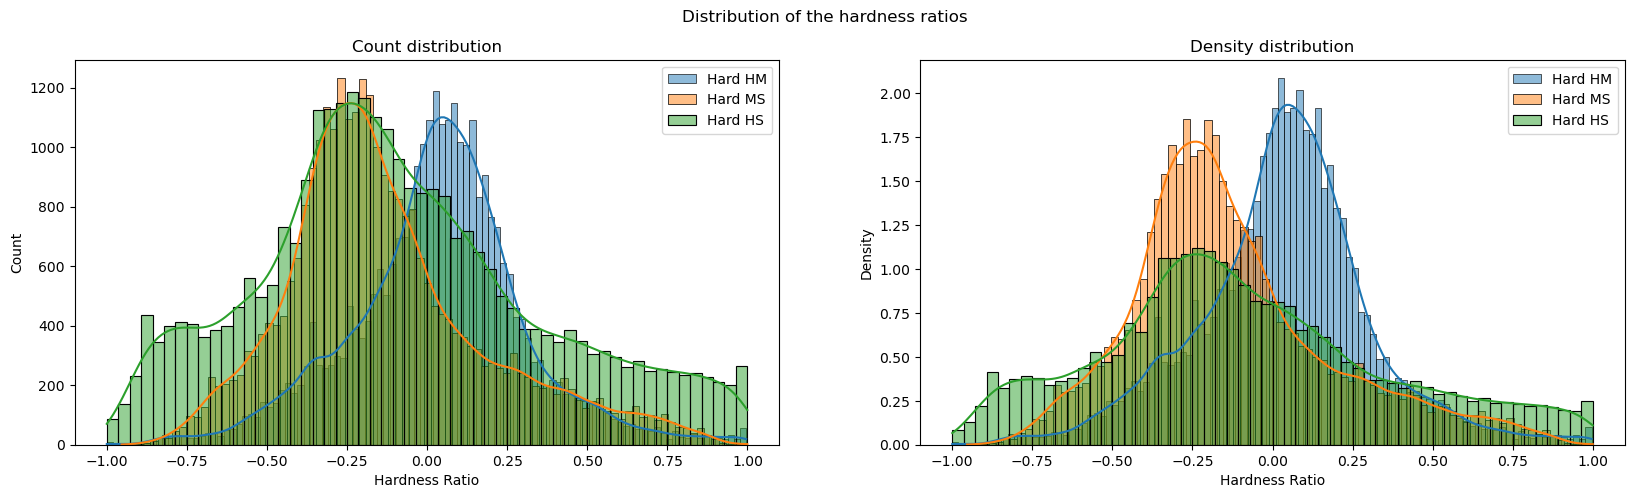

In [27]:
seaborn_histplot(subset_of_df, ['hard_hm', 'hard_ms', 'hard_hs'], ['Hard HM', 'Hard MS', 'Hard HS'], 'Distribution of the hardness ratios', 'Hardness Ratio')

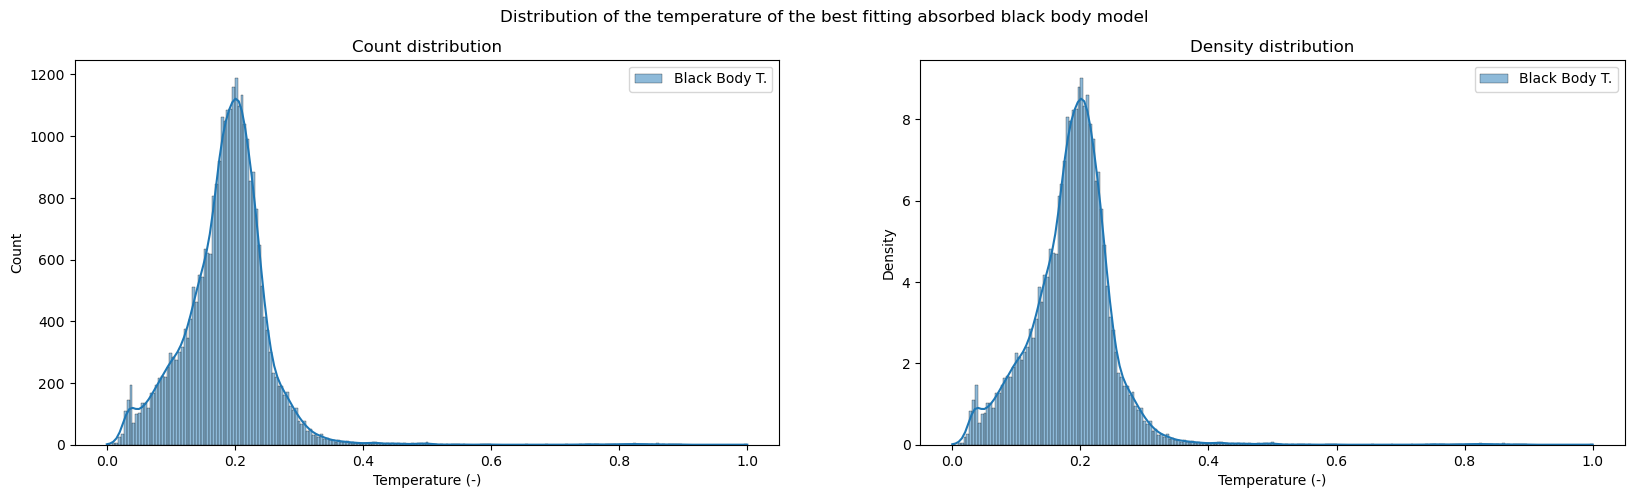

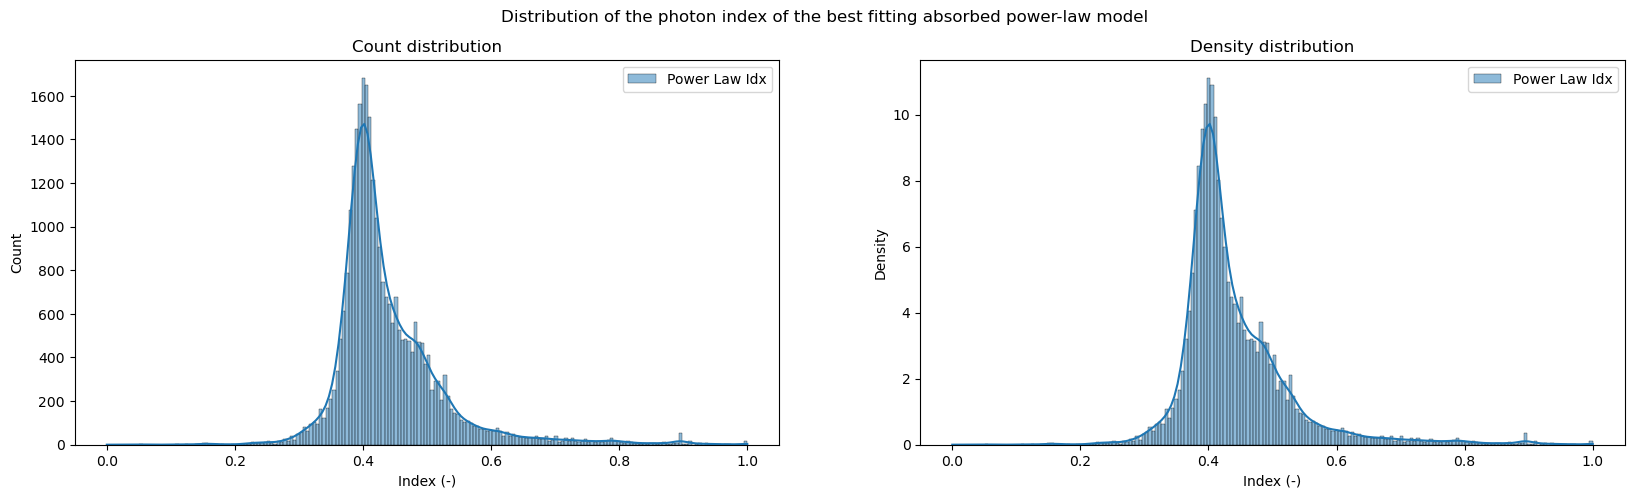

In [28]:
seaborn_histplot(subset_of_df, ['bb_kt'], ['Black Body T.'], 'Distribution of the temperature of the best fitting absorbed black body model', 'Temperature (-)')
seaborn_histplot(subset_of_df, ['powlaw_gamma'], ['Power Law Idx'], 'Distribution of the photon index of the best fitting absorbed power-law model', 'Index (-)')

## Correlation Heatmaps

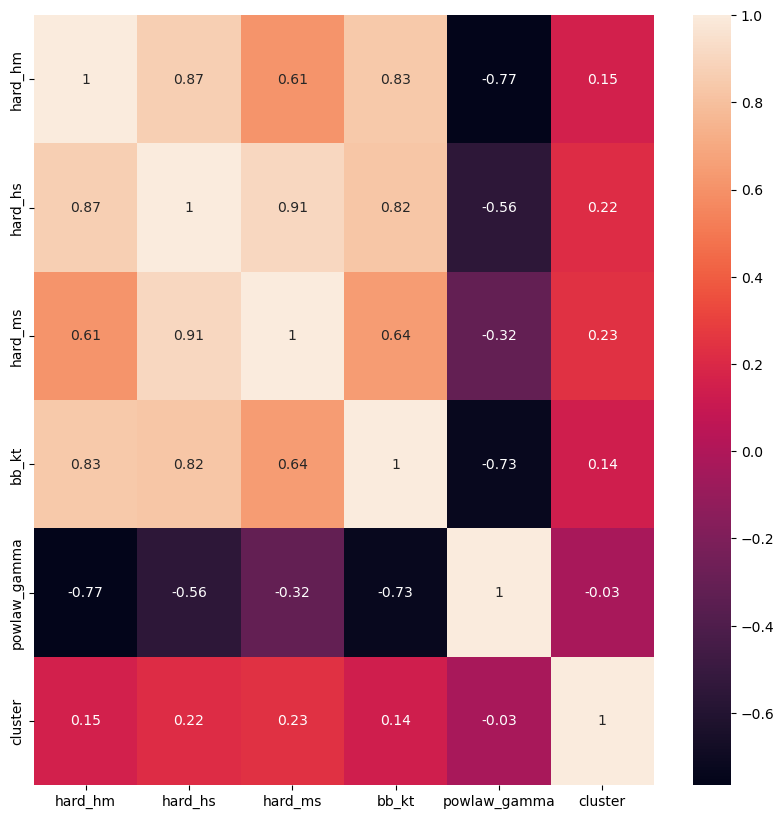

In [29]:
#data_and_target = pd.concat([df, pd.DataFrame(GMM_cluster_labels, columns=["GMM Cluster"])], axis=1)
df_and_cluster = pd.concat([subset_of_df, GMM_cluster_labels], axis=1)
Var_Corr = df_and_cluster.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)
plt.show()

## SOM
### with random hyperparameters

Obtaining the correspoinding Numpy matrix

In [30]:
# Get the dataset as a numpy array
X = subset_of_df.to_numpy()

In the following code we are training a 2-D SOM to reduce the dimensionalty of the data. As a rule of thumb for choosing the number of dim: 5 * sqrt(n) where n is the number of samples [GAMA paper]

In [31]:
len_data = len(X)
print('Number of data points: {}'.format(len_data))
dim_number = 50 # TO CHANGE with -> int(5 * np.sqrt(len_data))
print('Number of dimensions: {}'.format(dim_number))
print('Number of features: {}'.format(features))
train_iterations = 100

Number of data points: 29655
Number of dimensions: 50
Number of features: 5


In [32]:
som = MiniSom(dim_number, dim_number, features, sigma=1.5, learning_rate=.5)
som.train(X, train_iterations, verbose=True) # trains the SOM with 100 iterations

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.13958821744329322


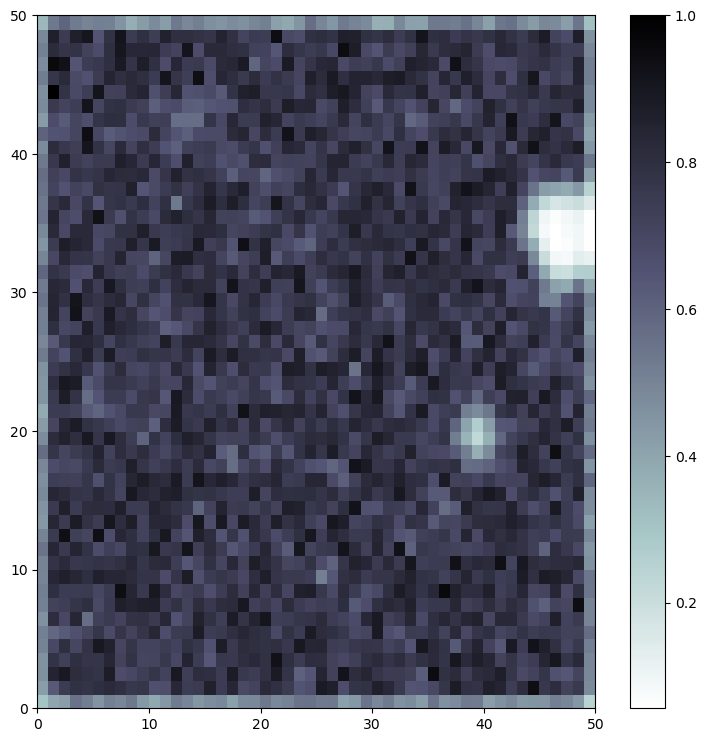

In [33]:
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the dataset
# different colors and markers for each label
markers = ['o', 's', 'D', 'v', '^', 'p']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

'''
for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[GMM_cluster_labels[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[GMM_cluster_labels[cnt]-1], markersize=12, markeredgewidth=2)
'''

plt.show()

## MiniSom's Hyperparameters:
- x: number of columns*
- y: number of rows
- sigma: spread of the neighborhood function (needs to be adequate to the dimensions of the map. sigma < x/2.0 and sigma < y/2.0)
- learning rate
- iterations  

## Error to minimize:

The Quantization Error** is computed by determining the average distance of the sample vectors to the cluster centroids by which they are represented.

*The QE, declines as the map becomes larger. Thus, the QE can not be used to compare maps of different sizes. Polzlbauer (2004)  
*The number of columns and rows should be 5 * sqrt(len(N)) Vesanto (2005)

In [34]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import time

In [35]:
def train_som(x, Y, input_len, sigma, learning_rate, train_iterations):
    # initialization
    som = MiniSom(x=x, y=Y, input_len=input_len, sigma=sigma, learning_rate=learning_rate)
    som.random_weights_init(X)
    # training
    start_time = time.time()
    som.train_random(X, train_iterations) # training with 100 iterations
    elapsed_time = time.time() - start_time
    print(elapsed_time, "seconds")
    return som

def plot_som(som):
    plt.figure(figsize=(10, 10))
    plt.bone()
    plt.pcolor(som.distance_map().T)
    plt.colorbar()
    '''
    markers = ['o', 's', 'D', 'v', '^', 'p']
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
    for cnt, xx in enumerate(X):
        w = som. winner(xx)
        # palce a marker on the winning position for the sample x
        plt.plot(w[0]+.5, w[1]+.5, markers[GMM_cluster_labels[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[GMM_cluster_labels[cnt]-1], markersize=12, markeredgewidth=2)
    '''
    plt.axis([0, som._weights.shape[0], 0, som._weights.shape[1]])
    plt.show()

## Tuning Sigma and LR by Reducing Quantization Error with hyperopt.fmin
1. Given observed values of the loss function, f(x), update the posterior expectation of fusing the Gaussian Process model.
2. Find xnew that maximises the Expected Improvement (El): xnew=argmaxEl(x).
3. Compute the value of f for the point new.  


Thomas Huijskens' Github: (https://github.com/thuijskens/bayesian-optimization)

In [36]:
space={
    'sig': hp.uniform('sig', 0.001, 5), 
    'learning_rate': hp.uniform('learning_rate', 0.001, 5)
    }

def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=dim_number, y=dim_number, input_len=features, sigma=sig, learning_rate=learning_rate).quantization_error(X)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=som_fn, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print('best: {}'.format (best))

for i, trial in enumerate(trials.trials[:2]):
    print(i, trial)

0.38177483207039487                                    
0.38852875117805263                                                               
0.39209538308198444                                                               
0.392904840329685                                                                 
0.39607371529742585                                                               
0.4029799449426509                                                                
0.392166799146975                                                                 
0.3903590275034003                                                                
0.3887286085427137                                                                
0.3871705639765126                                                                
0.38192148594282094                                                                
0.3959347121684701                                                                 
0.3919813018677232           

In [37]:
sigma = best['sig']
learning_rate = best['learning_rate']
print ("x: {},\ny: {},\ninput_len: {},\nsigma: {},\nlearning_rate: {}".format (dim_number, dim_number, features, sigma, learning_rate))

x: 50,
y: 50,
input_len: 5,
sigma: 2.139584836275415,
learning_rate: 1.4198123189186824


In [38]:
                #40k is the number of neurons in the SOM (NOT the raccomended number of neurons)
som = train_som(dim_number, dim_number, features, sigma, learning_rate,train_iterations)

0.012980937957763672 seconds


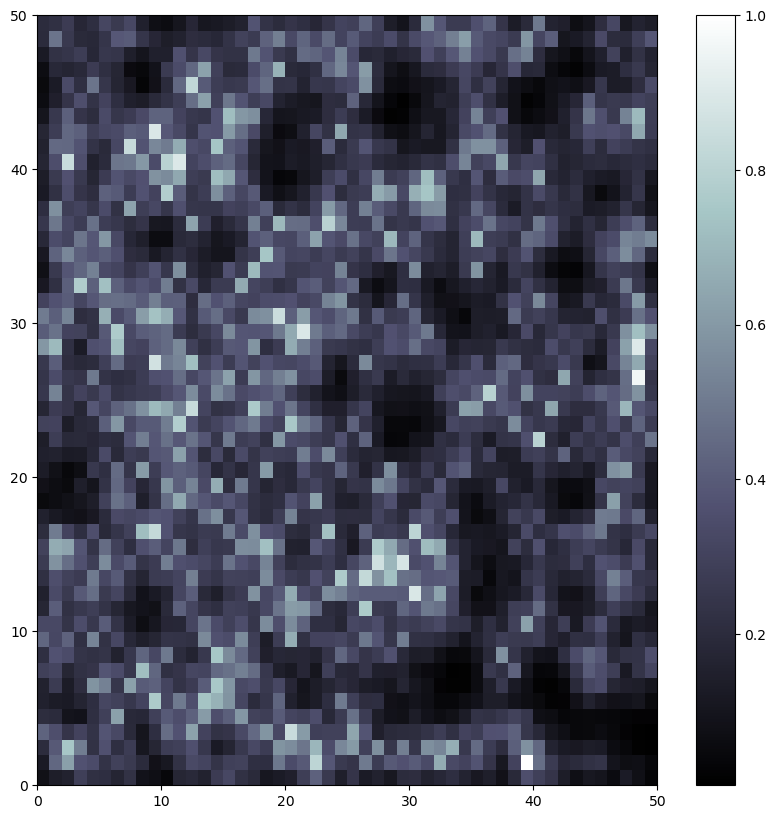

In [39]:
plot_som(som)